# COMPUTING THE STRUCTURAL DIVERSITY INDEX OF A RANDOM WALK ON A GRAPH

In this Jupyter Notebook we provide examples explaining how to use compute the structural diversity index of a network g using our scripts.

## DISCLAIMER: CUDA vs NOT CUDA

CUDA (or Compute Unified Device Architecture) is a parallel computing platform and application programming interface (API) that allows software to use certain types of graphics processing units (GPUs) for general purpose processing, an approach called general-purpose computing on GPUs (GPGPU).
Our scripts have the possibility to run on GPUs by using CUDA.
However, this requires to create a conda environment and install the packages in environment.yml as explained in the Installation section of the README.md on [GitHub](https://github.com/ethz-coss/Structural-diversity-index)

### IMPORTS
Here we import the packages required to run the example

In [128]:
# The structural diversity index package
import structural_diversity_index as sdi
# We import color maps form matplotlib in order to make nice visualizations
import matplotlib.pyplot as plt
# We import numpy 
import numpy as np
# We import networkx to process networks
import networkx as nx

## STEP 1: GENERATE A GRAPH USING NETWORKX

We generate a Barabasi-Albert network with 50 nodes and minimal degree m = 3

In [129]:
g = nx.barabasi_albert_graph(n=50, m=3)

Here is a visualizaiton of the network

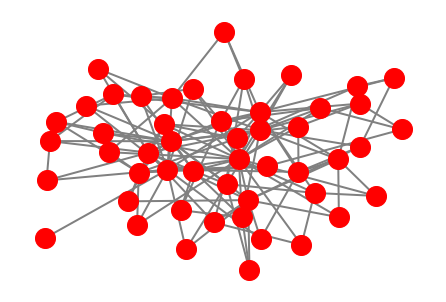

In [130]:
nx.draw(g, pos=nx.spring_layout(g), node_size=400, node_color='Red', edge_color='Grey', width=2)

## STEP2: COMPUTE THE MEETING TIME OF THE GRAPH

We compute the meeting time of a uniformly started random walk on g. We need to feed in 4 parameters.
   * g: the graph for which you want to compute the meeting time
   * max_time_steps: the maximum number of time steps for which you want to run random walks to compute their meeting time. The random walks will run for max_time_steps and then stop. If some walks have not met before we stop them, we use the methods in MeetingTimeEstimator to estimate the meeting time of those walks.
   * n_samples: the number of samples of the meeting time that you want to get
   * on_cuda: if True, use cuda. If False, do not use cuda.

In [131]:
# We run the random walks for 10 * g.number_of_nodes() at most
max_time_steps = 10 * g.number_of_nodes()
# We want 1000 samples of the random walks
n_samples = 1000
# Here we run computations on CPUd
# If you have GPUs and have installed the packages in environment.yml (as explained in the Installation section of the README.md on GitHub)
# you can set on_cuda = True and your computations wil run on GPUs. This will make them faster for large networks.
on_cuda = False

In [132]:
meeting_times = sdi.UI.get_meeting_times(g=g, max_time_steps=max_time_steps, n_samples=n_samples, on_cuda=on_cuda)

 45%|████▌     | 225/499 [00:00<00:00, 2741.83it/s]


We plot a histogram with the meeting time distribution

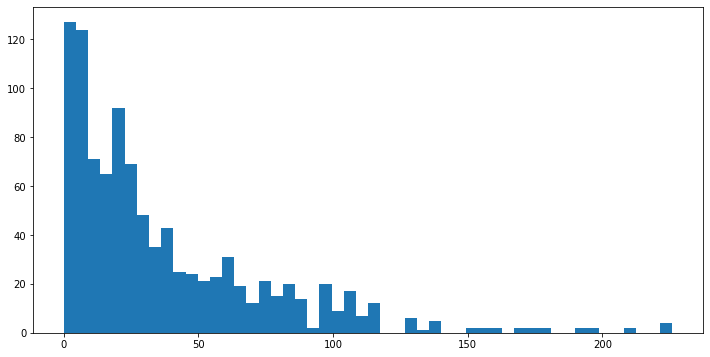

In [133]:
fig, ax = plt.subplots(figsize=(12,6))
hist_data = ax.hist(meeting_times, bins=50)

## STEP 3: COMPUTE THE STRUCTURAL DIVERSITY INDEX

The structural diversity index Delta(g) is the ratio between the average meeting time and the number of nodes of the graph.
Below we compute it and give 95% confidence intervals for its value.


In [134]:
# The structural diversity index
structural_diversity_index = np.mean(meeting_times)/g.number_of_nodes()

# The confidence intervals
z = 1.96 # z_value for 95% confidence intervals
confidence_interval_size = z*np.std(meeting_times/g.number_of_nodes())/np.sqrt(n_samples)

# Print out the results
print(f'The structural diversity index of g is Delta(g) = {structural_diversity_index} +- {confidence_interval_size}')

The structural diversity index of g is Delta(g) = 0.75378 +- 0.04800238523326274


## STEP 4: DIRECTLY COMPUTING THE STRUCTURAL DIVERSITY INDEX

There is a more direct way to compute the structural diversity index using the structural_diversity_index package. The inputs are the same as the one fed above.

In [135]:
structural_diversity_index, std = sdi.UI.get_structural_diversity_index(g=g, max_time_steps=max_time_steps, n_samples=n_samples, on_cuda=on_cuda)

# The confidence intervals
z = 1.96 # z_value for 95% confidence intervals
confidence_interval_size = z*std/np.sqrt(n_samples)

# Print out the results
print(f'The structural diversity index of g is Delta(g) = {structural_diversity_index} +- {confidence_interval_size}')

 53%|█████▎    | 263/499 [00:00<00:00, 2687.10it/s]

The structural diversity index of g is Delta(g) = 0.6973999999999999 +- 0.043231559650607106


Hope you enjoyed this tutorial!